In [1]:
pip install pandas


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Data Cleaning, Creating Database using SQLlite to process the data smoothly
import sqlite3
import pandas as pd

# Specify the path to your Excel file and output CSV file
file_path = '250304 PDAC Hack Risk data v5.0 clean.xlsx'
output_csv_file = 'risk_mitigations_export.csv'
db_path = 'risk_mitigations.db'

# Step 1: Read the Excel file with debugging
print(f"Attempting to read file: {file_path}")
excel_file = pd.ExcelFile(file_path)
print("Available sheet names:", excel_file.sheet_names)

try:
    risk_df = pd.read_excel(file_path, sheet_name='Risks')
    mitigation_df = pd.read_excel(file_path, sheet_name='Mitigations')
    print("Successfully read 'Risks' and 'Mitigations' sheets.")
    print("Risk Sheet Columns:", risk_df.columns.tolist())
    print("Mitigation Sheet Columns:", mitigation_df.columns.tolist())
except ValueError as e:
    print(f"Error reading sheets: {e}. Please check sheet names above and update the script.")
    exit()
except Exception as e:
    print(f"Unexpected error: {e}. Check file path or permissions.")
    exit()

# Step 2: Clean the data
def clean_risk_data(df):
    print("Cleaning Risk Data...")
    df.columns = [col.replace(' ', '_').replace('.', '') for col in df.columns]  # Remove spaces and dots
    
    date_cols = ['Report_Date', 'Start', 'Relief']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    if 'Risk_Type' in df.columns:
        df['Risk_Type'] = df['Risk_Type'].replace({'Opportunitity': 'Opportunity'})

    numeric_cols = ['Pre_Prob', 'Pre_Cost', 'Pre_Factored_Cost', 'Post_Prob', 'Post_Cost', 'Post_Factored_Cost',
                    'PreMit_Sched_Impact_Prob', 'PreMit_Sched_Impact_Min', 'PreMit_Sched_Impact_Most_Likely',
                    'PreMit_Sched_Impact_Max', 'PreMit_Sched_Impact', 'PreMit_Sched_Impact_Prob_1',
                    'PostMit_Sched_Impact_Min', 'PostMit_Sched_Impact_Most_Likely', 'PostMit_Sched_Impact_Max',
                    'PostMit_Sched_Impact']
    for col in [c for c in numeric_cols if c in df.columns]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    if 'Trend' in df.columns:
        df['Trend'] = df['Trend'].replace('--', 'Stable')
    df.fillna({'Pre_Prob': 0, 'Pre_Cost': 0, 'Post_Prob': 0, 'Post_Cost': 0}, inplace=True)

    if 'Risk_Unique_ID' in df.columns:
        df.drop_duplicates(subset=['Risk_Unique_ID'], keep='last', inplace=True)

    return df

def clean_mitigation_data(df):
    print("Cleaning Mitigation Data...")
    df.columns = [col.replace(' ', '_').replace('-', '_') for col in df.columns]  # Replace spaces and hyphens
    
    # Fix typo in 'Risk-roject_ID' to 'Project_ID'
    if 'Risk_roject_ID' in df.columns:
        df.rename(columns={'Risk_roject_ID': 'Project_ID'}, inplace=True)
    elif 'Project_ID' not in df.columns:
        raise KeyError("No suitable 'Project_ID' column found in Mitigation sheet. Check column names.")

    if 'Report_Date' in df.columns:
        df['Report_Date'] = pd.to_datetime(df['Report_Date'], errors='coerce')

    if 'Serial' in df.columns:
        df['Serial'] = pd.to_numeric(df['Serial'], errors='coerce', downcast='integer')

    rename_dict = {
        'Report_Date': 'Mit_Report_Date',
        'Unique_Mitigation_ID': 'Mit_Unique_ID',
        'Mit_Action_Owner': 'Mit_Action_Owner',
        'Action_Description': 'Mit_Action_Description',
        'Serial': 'Mit_Serial'
    }
    df = df.rename(columns={k: v for k, v in rename_dict.items() if k in df.columns})

    if 'Mit_Action_Description' in df.columns:
        df['Mit_Action_Description'] = df['Mit_Action_Description'].fillna('No description provided')

    if 'Mit_Unique_ID' in df.columns:
        df.drop_duplicates(subset=['Mit_Unique_ID'], keep='last', inplace=True)

    return df

# Clean the DataFrames
risk_df = clean_risk_data(risk_df)
mitigation_df = clean_mitigation_data(mitigation_df)

# Step 3: Merge the DataFrames
print("Merging DataFrames...")
risk_df['merge_key'] = risk_df['Project_ID'] + '_' + risk_df['Risk_ID']
mitigation_df['merge_key'] = mitigation_df['Project_ID'] + '_' + mitigation_df['Risk_ID']

combined_df = pd.merge(risk_df, mitigation_df, on='merge_key', how='left', suffixes=('', '_mit'))
combined_df['Risk_Unique_ID'] = combined_df['Risk_Unique_ID'].fillna(combined_df['merge_key'])
combined_df = combined_df.drop(columns=['merge_key'] + [col for col in combined_df.columns if col.endswith('_mit')])

# Step 4: Create SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS Risk_Mitigations (
    Report_Date DATETIME,
    Organisation TEXT,
    Business_Area TEXT,
    Portfolio_ID TEXT,
    Project_ID TEXT,
    Risk_ID TEXT,
    Risk_Unique_ID TEXT,
    Risk_Type TEXT,
    Cont TEXT,
    Status TEXT,
    Criticality TEXT,
    Main_Risk_Cat TEXT,
    Risk TEXT,
    Owner TEXT,
    Start DATETIME,
    Relief DATETIME,
    Pre_Prob REAL,
    Pre_Cost REAL,
    Pre_Factored_Cost REAL,
    Strategy TEXT,
    Post_Prob REAL,
    Post_Cost REAL,
    Post_Factored_Cost REAL,
    PostMit_Criticality TEXT,
    Trend TEXT,
    PreMit_Sched_Impact_Prob REAL,
    PreMit_Sched_Impact_Min REAL,
    PreMit_Sched_Impact_Most_Likely REAL,
    PreMit_Sched_Impact_Max REAL,
    PreMit_Sched_Impact REAL,
    PreMit_Sched_Impact_Prob_1 REAL,
    PostMit_Sched_Impact_Min REAL,
    PostMit_Sched_Impact_Most_Likely REAL,
    PostMit_Sched_Impact_Max REAL,
    PostMit_Sched_Impact REAL,
    Mit_Serial INTEGER,
    Mit_Report_Date DATETIME,
    Mit_Unique_ID TEXT,
    Mit_Action_Owner TEXT,
    Mit_Action_Description TEXT
)
''')

# Insert data
combined_df.to_sql('Risk_Mitigations', conn, if_exists='replace', index=False)
conn.commit()

# Step 5: Count rows
row_count = pd.read_sql_query("SELECT COUNT(*) as total_rows FROM Risk_Mitigations", conn).iloc[0]['total_rows']
print(f"Total number of rows in Risk_Mitigations: {row_count}")

# Step 6: Data checks
print("\nPerforming data checks...")
null_counts = pd.read_sql_query("""
    SELECT 
        SUM(CASE WHEN Risk_Unique_ID IS NULL THEN 1 ELSE 0 END) as null_risk_unique_id,
        SUM(CASE WHEN Project_ID IS NULL THEN 1 ELSE 0 END) as null_project_id,
        SUM(CASE WHEN Risk_ID IS NULL THEN 1 ELSE 0 END) as null_risk_id
    FROM Risk_Mitigations
""", conn)
print("Null counts in key columns:")
print(null_counts)

duplicate_risks = pd.read_sql_query("""
    SELECT Risk_Unique_ID, COUNT(*) as count 
    FROM Risk_Mitigations 
    GROUP BY Risk_Unique_ID 
    HAVING count > 1 
    LIMIT 5
""", conn)
print("\nTop 5 duplicate Risk_Unique_IDs (if any):")
print(duplicate_risks if not duplicate_risks.empty else "No duplicates found.")

cost_stats = pd.read_sql_query("""
    SELECT 
        AVG(Pre_Cost) as avg_pre_cost,
        MIN(Pre_Cost) as min_pre_cost,
        MAX(Pre_Cost) as max_pre_cost
    FROM Risk_Mitigations
""", conn)
print("\nPre_Cost statistics:")
print(cost_stats)

unique_key_check = pd.read_sql_query("""
    SELECT Risk_Unique_ID, Mit_Serial, COUNT(*) as count
    FROM Risk_Mitigations
    GROUP BY Risk_Unique_ID, Mit_Serial
    HAVING count > 1
    LIMIT 5
""", conn)
print("\nCheck for duplicates in (Risk_Unique_ID, Mit_Serial):")
print(unique_key_check if not unique_key_check.empty else "No duplicates found - (Risk_Unique_ID, Mit_Serial) is unique.")

# Step 7: Export to CSV file
print(f"\nExporting table to {output_csv_file}...")
export_df = pd.read_sql_query("SELECT * FROM Risk_Mitigations", conn)
export_df.to_csv(output_csv_file, index=False)
print(f"Table exported successfully to {output_csv_file}")

# Verify sample
print("\nCombined Risk_Mitigations Table Sample:")
sample_df = pd.read_sql_query("SELECT Risk_Unique_ID, Risk, Pre_Cost, Mit_Serial, Mit_Action_Description FROM Risk_Mitigations LIMIT 5", conn)
print(sample_df)

#conn.close()

Attempting to read file: 250304 PDAC Hack Risk data v5.0 clean.xlsx
Available sheet names: ['Mitigations', 'Risks', 'Risks with Mitigations']
Successfully read 'Risks' and 'Mitigations' sheets.
Risk Sheet Columns: ['Report Date', 'Organisation', 'Business Area', 'Portfolio ID', 'Project ID', 'Risk ID', 'Risk Unique ID', 'Risk Type', 'Cont', 'Status', 'Criticality', 'Main Risk Cat.', 'Risk', 'Owner', 'Start', 'Relief', 'Pre Prob', 'Pre Cost', 'Pre Factored Cost', 'Strategy', 'Post Prob', 'Post Cost', 'Post Factored Cost', 'PostMit_Criticality', 'Trend', 'PreMit_Sched_Impact_Prob', 'PreMit_Sched_Impact_Min', 'PreMit_Sched_Impact_Most_Likely', 'PreMit_Sched_Impact_Max', 'PreMit_Sched_Impact', 'PreMit_Sched_Impact_Prob_1', 'PostMit_Sched_Impact_Min', 'PostMit_Sched_Impact_Most_Likely', 'PostMit_Sched_Impact_Max', 'PostMit_Sched_Impact']
Mitigation Sheet Columns: ['Serial', 'Report Date', 'Risk-roject ID', 'Risk ID', 'Unique_Mitigation_ID', 'Mit Action Owner', 'Action Description', 'Risk Un

In [5]:
#Mandatory installation of hugging face
!pip install huggingface_hub


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Welcome to the Risk Mitigation Chatbot with Hugging Face!
Ask me anything about the Risk_Mitigations data (e.g., 'What are the risks for Project_001?').
Type 'exit' to quit.

Columns in Risk_Mitigations table:
['Report_Date', 'Organisation', 'Business_Area', 'Portfolio_ID', 'Project_ID', 'Risk_ID', 'Risk_Unique_ID', 'Risk_Type', 'Cont', 'Status', 'Criticality', 'Main_Risk_Cat', 'Risk', 'Owner', 'Start', 'Relief', 'Pre_Prob', 'Pre_Cost', 'Pre_Factored_Cost', 'Strategy', 'Post_Prob', 'Post_Cost', 'Post_Factored_Cost', 'PostMit_Criticality', 'Trend', 'PreMit_Sched_Impact_Prob', 'PreMit_Sched_Impact_Min', 'PreMit_Sched_Impact_Most_Likely', 'PreMit_Sched_Impact_Max', 'PreMit_Sched_Impact', 'PreMit_Sched_Impact_Prob_1', 'PostMit_Sched_Impact_Min', 'PostMit_Sched_Impact_Most_Likely', 'PostMit_Sched_Impact_Max', 'PostMit_Sched_Impact', 'Mit_Serial', 'Mit_Report_Date', 'Mit_Unique_ID', 'Mit_Action_Owner', 'Mit_Action_Description']

Available Project_IDs (first 5):
 Project_ID
Project_030
Projec


Ask me something:  Return all risk with criticality classification of H1 and sorting by Main Risk Category


Translating: 'Return all risk with criticality classification of H1 and sorting by Main Risk Category'
Raw HF response: '-----------------------------------------------------------------------------------------
                SELECT DISTINCT Risk_Unique_ID, Risk, Pre_Factored_Cost
                FROM Risk_Mitigations
                WHERE Criticality = 'H1'
                ORDER BY Main_Risk_Cat'
Generated SQL: SELECT DISTINCT Risk_Unique_ID, Risk, Pre_Factored_Cost
                FROM Risk_Mitigations
                WHERE Criticality = 'H1'
                ORDER BY Main_Risk_Cat

Results:
       Risk_Unique_ID                                                                                                   Risk  Pre_Factored_Cost
 Project_093_Risk-014                                                             Increased Baseline Cost - External Funding           2.538503
  Project_084_Risk-30                                                                                      Site

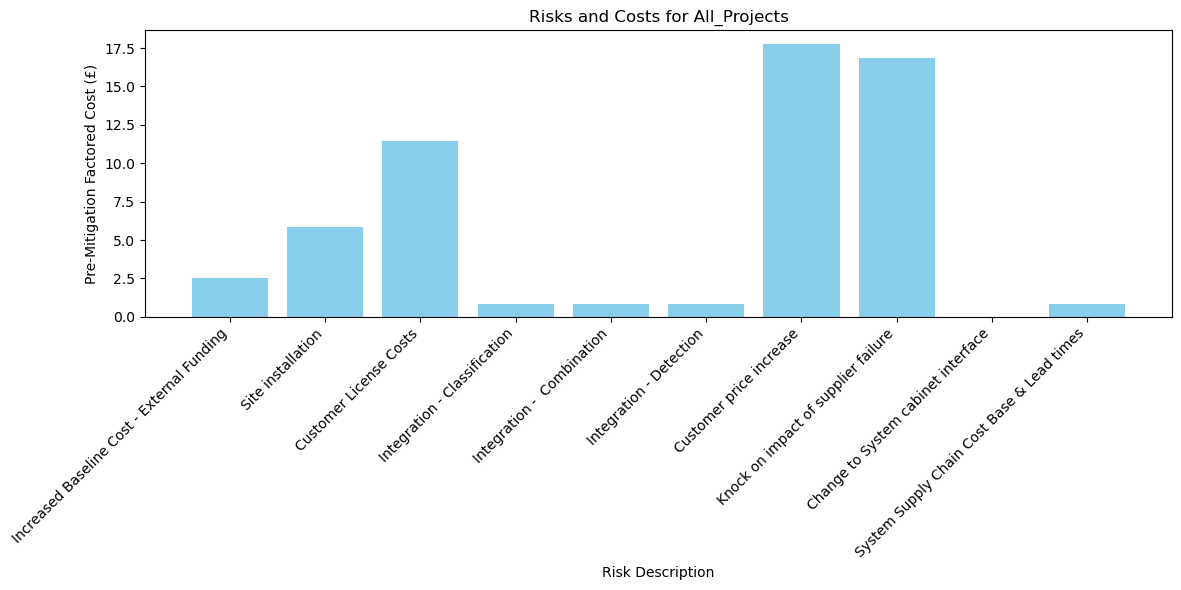

(Showing first 10 of 144 rows)



Ask me something:  Search for "Key" in fields to identify any re-occurring risks calculating trends over time.


Translating: 'Search for "Key" in fields to identify any re-occurring risks calculating trends over time.'
Raw HF response: '1. Identify risks with 'Key' in Risk_Type or Risk.
                2. Calculate the trend for each risk.

                SQL:
                SELECT DISTINCT Risk_Unique_ID, Risk, Pre_Factored_Cost, Trend
                FROM Risk_Mitigations
                WHERE (Risk_Type LIKE '%Key%' OR Risk LIKE '%Key%')
                ORDER BY Risk;'
Generated SQL: SELECT DISTINCT Risk_Unique_ID, Risk, Pre_Factored_Cost, Trend
                FROM Risk_Mitigations
                WHERE (Risk_Type LIKE '%Key%' OR Risk LIKE '%Key%')
                ORDER BY Risk;

Results:
      Risk_Unique_ID                                                                    Risk  Pre_Factored_Cost  Trend
 Project_041_Risk-78           Availability of key resource within production or Engineering           0.524772 Stable
Project_080_Risk-007                                             Ava

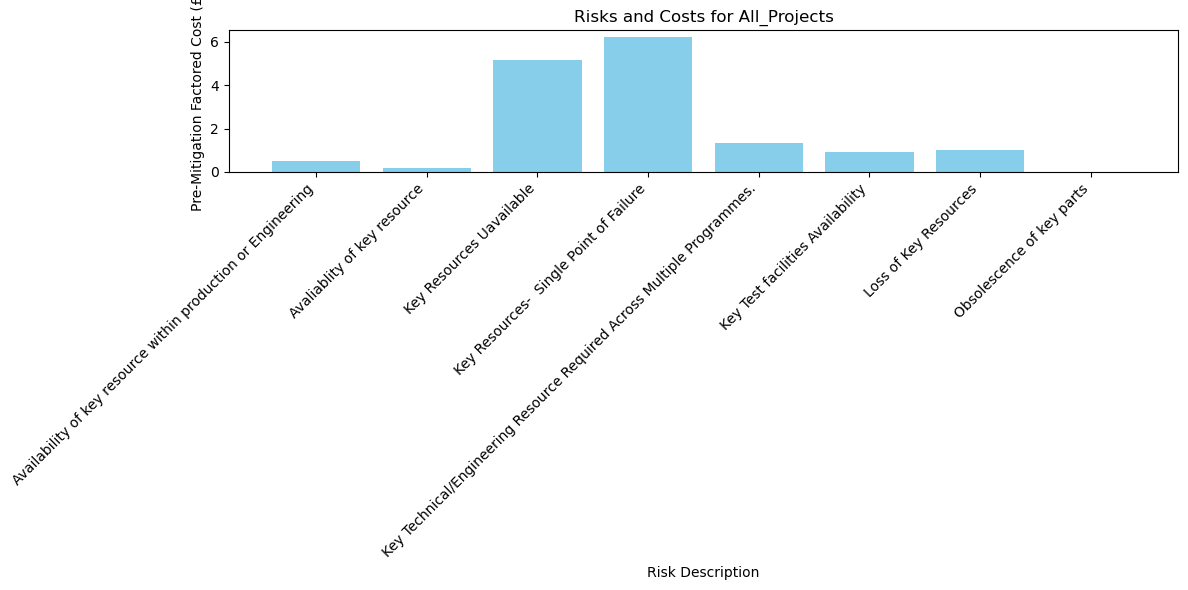

(Showing first 10 of 13 rows)



Ask me something:  What are the risks for Project_011?


Translating: 'What are the risks for Project_011?'
Raw HF response: 'SELECT DISTINCT Risk_Unique_ID, Risk, Pre_Factored_Cost
                FROM Risk_Mitigations
                WHERE Project_ID = 'Project_011';'
Generated SQL: SELECT DISTINCT Risk_Unique_ID, Risk, Pre_Factored_Cost
                FROM Risk_Mitigations
                WHERE Project_ID = 'Project_011';

Results:
      Risk_Unique_ID                                                                                                      Risk  Pre_Factored_Cost
Project_011_Risk-131                                         Support team have not covered all obligations in support contract           0.000000
Project_011_Risk-118                                                                               Customer change environment           0.000000
Project_011_Risk-117                                                                 Customer Avaliability for testing/reviews           0.000000
Project_011_Risk-115             

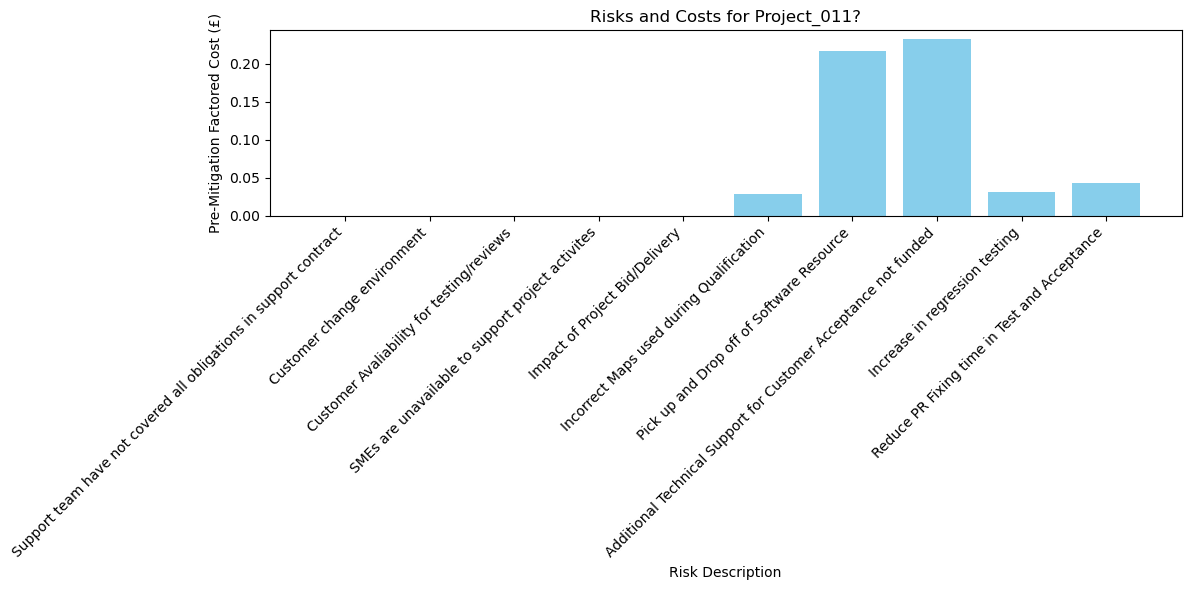

(Showing first 10 of 39 rows)



Ask me something:  exit


Goodbye!


In [ ]:
# chatbot query with visualisation as we don't have access to power BI
# Similarly, we can achieve using Power BI in coming future enhancement.
import sqlite3
import pandas as pd
import re
from huggingface_hub import InferenceClient
import time
from requests.exceptions import HTTPError
import matplotlib.pyplot as plt

# Paths and API key
db_path = 'risk_mitigations.db'
hf_api_key = 'Add your key here'

def connect_db():
    conn = sqlite3.connect(db_path)
    return conn

def query_db(query, params=()):
    conn = connect_db()
    try:
        df = pd.read_sql_query(query, conn, params=params)
    except Exception as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    conn.close()
    return df

def get_hf_response(prompt, retries=3, delay=5):
    client = InferenceClient(api_key=hf_api_key)
    for attempt in range(retries):
        try:
            response = client.text_generation(
                prompt=f"""
                You are an expert SQL assistant for the 'Risk_Mitigations' table. The table contains: Report_Date, Organisation, Business_Area, Portfolio_ID, Project_ID, Risk_ID, Risk_Unique_ID, Risk_Type, Status, Criticality, Main_Risk_Cat, Risk, Owner, Start, End, Pre_Prob, Pre_Cost, Pre_Factored_Cost, Strategy, Post_Prob, Post_Cost, Post_Factored_Cost, PostMit_Criticality, Trend, PreMit_Sched_Impact_Prob, PreMit_Sched_Impact_Min, PreMit_Sched_Impact_Most_Likely, PreMit_Sched_Impact_Max, PreMit_Sched_Impact, PreMit_Sched_Impact_Prob_1, PostMit_Sched_Impact_Min, PostMit_Sched_Impact_Most_Likely, PostMit_Sched_Impact_Max, PostMit_Sched_Impact, Mit_Serial, Mit_Report_Date, Mit_Unique_ID, Mit_Action_Owner, Mit_Action_Description. Project_ID format is 'Project_XXX'. Unique key is (Risk_Unique_ID, Mit_Serial). Use 'Risk' for risk descriptions.

                Rules:
                1. Return ONLY a valid SQL query as plain text, with no formatting lines, narrative, or comments.
                2. Use SELECT DISTINCT unless aggregation is required.
                3. Filter by Project_ID only if specified in the question.
                4. For 'risk' questions, select Risk_Unique_ID, Risk, Pre_Factored_Cost.
                5. Apply filters (e.g., 'criticality classification of H1') as exact conditions (e.g., Criticality = 'H1').
                6. For sorting (e.g., 'sorting by Main Risk Category'), use ORDER BY Main_Risk_Cat and include Main_Risk_Cat in SELECT.
                7. For 'root causes' or 'categories', use Risk_Type or Criticality.
                8. For 'schedule delays', use PreMit_Sched_Impact.
                9. For 'top' or 'common', use COUNT(*) or SUM, ORDER BY DESC, LIMIT 5.

                Query: {prompt}
                """,
                model="mistralai/Mistral-7B-Instruct-v0.2",
                max_new_tokens=200,
                temperature=0.1
            )
            response = response.strip()
            print(f"Raw HF response: '{response}'")
            # Extract SQL starting from the first SELECT
            sql_match = re.search(r'(?i)SELECT.*', response, re.DOTALL)
            if not sql_match:
                raise ValueError("Invalid SQL response: No SELECT statement found")
            sql_query = sql_match.group(0).strip()
            if 'FROM' not in sql_query.upper():
                raise ValueError("Invalid SQL response: Must contain FROM")
            return sql_query
        except HTTPError as e:
            if e.response.status_code == 503 and attempt < retries - 1:
                print(f"Hugging Face error 503: Retrying in {delay} seconds... (Attempt {attempt + 1}/{retries})")
                time.sleep(delay)
                continue
            print(f"Hugging Face error: {e}")
            return None
        except Exception as e:
            print(f"Hugging Face error: {e}")
            return None

def plot_risks(df, title):
    if df.empty or 'Risk' not in df.columns or 'Pre_Factored_Cost' not in df.columns:
        print("Cannot generate visualization: Data is missing required columns.")
        return
    
    df_unique = df.drop_duplicates(subset=['Risk_Unique_ID'])
    
    if 'Main_Risk_Cat' in df.columns:
        plt.figure(figsize=(12, 6))
        for cat in df_unique['Main_Risk_Cat'].unique():
            cat_data = df_unique[df_unique['Main_Risk_Cat'] == cat]
            plt.bar(cat_data['Risk'][:5], cat_data['Pre_Factored_Cost'][:5], label=cat)  # Limit to 5 risks per category
        plt.xlabel('Risk Description')
        plt.ylabel('Pre-Mitigation Factored Cost (£)')
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
    else:
        plt.figure(figsize=(12, 6))
        plt.bar(df_unique['Risk'][:10], df_unique['Pre_Factored_Cost'][:10], color='skyblue')  # Limit to 10 risks
        plt.xlabel('Risk Description')
        plt.ylabel('Pre-Mitigation Factored Cost (£)')
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
    
    plt.savefig(f'{title.replace(" ", "_")}.png')
    print(f"Visualization saved as '{title.replace(' ', '_')}.png'")
    plt.show()

def chatbot():
    print("Welcome to the Risk Mitigation Chatbot with Hugging Face!")
    print("Ask me anything about the Risk_Mitigations data (e.g., 'What are the risks for Project_001?').")
    print("Type 'exit' to quit.")
    
    conn = connect_db()
    cursor = conn.cursor()
    cursor.execute("PRAGMA table_info(Risk_Mitigations)")
    columns = [row[1] for row in cursor.fetchall()]
    print("\nColumns in Risk_Mitigations table:")
    print(columns)
    conn.close()
    
    print("\nAvailable Project_IDs (first 5):")
    project_ids = query_db("SELECT DISTINCT Project_ID FROM Risk_Mitigations LIMIT 5")
    print(project_ids.to_string(index=False))
    
    while True:
        user_input = input("\nAsk me something: ").strip()
        if user_input.lower() == 'exit':
            print("Goodbye!")
            break
        if not user_input:
            print("Please enter a question.")
            continue
        
        print(f"Translating: '{user_input}'")
        sql_query = get_hf_response(user_input)
        
        if sql_query is None or not sql_query.strip():
            print("Sorry, I couldn’t generate a valid SQL query. See error above.")
            continue
        
        print(f"Generated SQL: {sql_query}")
        df = query_db(sql_query)
        
        if df.empty:
            print("No results found. Check the query.")
        else:
            print("\nResults:")
            print(df.to_string(index=False))
            
            project_id = user_input.split()[-1] if 'Project_' in user_input else 'All_Projects'
            if "risk" in user_input.lower():  # Broadened condition to catch "risk" in any form
                title = f'Risks and Costs for {project_id}'
                plot_risks(df, title)
        
        if len(df) > 10:
            print(f"(Showing first 10 of {len(df)} rows)")

if __name__ == "__main__":
    chatbot()